# プロフェッショナル編：時系列予測のベースライン

このノートブックでは，`professional.ipynb` のタイタニック例と同じ流れを，**1 本の時系列データ（毎日の売上）** を題材にして体験できるように構成しています。

- 0. データの用意と可視化（ここでは合成データを自動生成）
- 1. 時系列特徴量エンジニアリング（ラグ・移動平均・カレンダー特徴など）
- 2. 時系列を意識した学習・検証・テストへの分割
- 3. ランダムフォレストによるベースラインモデルの学習
- 4. 予測性能の評価（RMSE）と，実データとの比較可視化

`professional.ipynb` では分類問題（生存 / 非生存）を扱いましたが，ここでは **将来の連続値（売上）を予測する回帰問題** を扱います。コード自体はコンパクトですが，実務の時系列予測でも頻出する「特徴量の作り方」「時間を壊さない分割方法」「ベースラインモデルの作り方」を一通り確認できるようになっています。


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.style.use("seaborn-v0_8-whitegrid")
RANDOM_SEED = 42



In [22]:
rng = pd.date_range("2018-01-01", periods=1200, freq="D")
trend = np.linspace(0, 10, len(rng))
seasonal = 4 * np.sin(2 * np.pi * rng.dayofyear / 365)
weekly = 1.5 * np.sin(2 * np.pi * rng.dayofweek / 7)
noise = np.random.default_rng(RANDOM_SEED).normal(0, 0.8, len(rng))
sales = 100 + trend + seasonal + weekly + noise

df = pd.DataFrame({"timestamp": rng, "sales": sales})
df.head()



,timestamp,sales
0,2018-01-01,100.312627
1,2018-01-02,100.486787
2,2018-01-03,102.285912
3,2018-01-04,101.703508
4,2018-01-05,98.165567


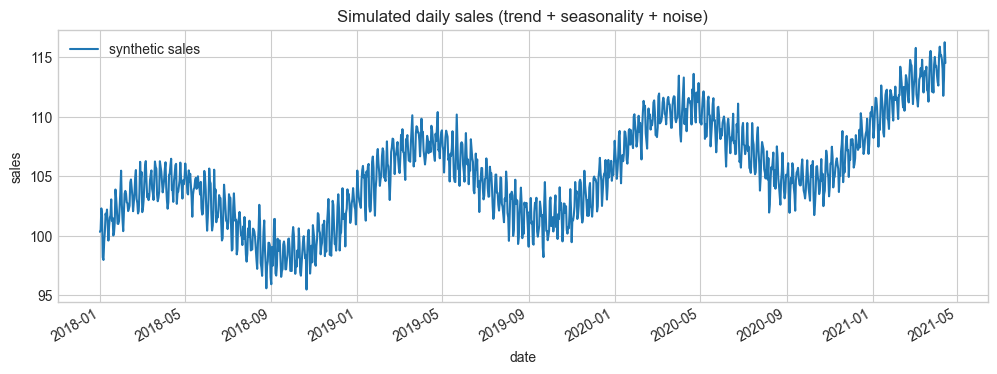

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["timestamp"], df["sales"], label="synthetic sales", color="#1f77b4")
ax.set_title("Simulated daily sales (trend + seasonality + noise)")
ax.set_xlabel("date")
ax.set_ylabel("sales")
ax.legend(loc="upper left")
fig.autofmt_xdate()
plt.show()



In [24]:
def prepare_features(dataframe: pd.DataFrame) -> pd.DataFrame:
    features = dataframe.copy()
    for lag in (1, 7, 30):
        features[f"lag_{lag}"] = features["sales"].shift(lag)
    features["roll_mean_7"] = features["sales"].shift(1).rolling(window=7).mean()
    features["roll_std_30"] = features["sales"].shift(1).rolling(window=30).std()
    features["month"] = features["timestamp"].dt.month
    features["dayofweek"] = features["timestamp"].dt.dayofweek
    features["dayofyear"] = features["timestamp"].dt.dayofyear
    return features.dropna()

features = prepare_features(df)
# データの実際の範囲に合わせて分割（1200日 ≈ 3.3年）
train = features[features["timestamp"] < "2020-01-01"]
valid = features[(features["timestamp"] >= "2020-01-01") & (features["timestamp"] < "2021-01-01")]
test = features[features["timestamp"] >= "2021-01-01"]

feature_cols = [col for col in features.columns if col not in ("timestamp", "sales")]

X_train, y_train = train[feature_cols], train["sales"]
X_valid, y_valid = valid[feature_cols], valid["sales"]
X_test, y_test = test[feature_cols], test["sales"]

X_train.shape, X_valid.shape, X_test.shape



((700, 8), (366, 8), (104, 8))

In [25]:
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
model.fit(X_train, y_train)

valid_pred = model.predict(X_valid)
test_pred = model.predict(X_test)

rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Validation RMSE: {rmse(y_valid, valid_pred):.3f}")
print(f"Test RMSE: {rmse(y_test, test_pred):.3f}")



Validation RMSE: 1.581
Test RMSE: 4.447


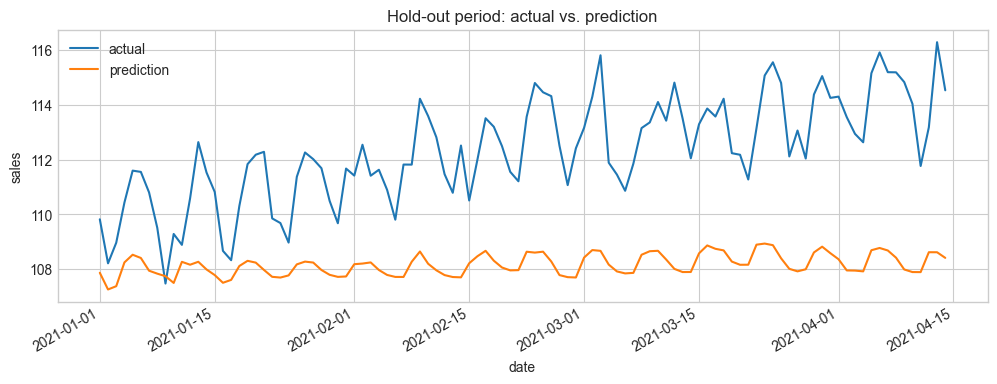

In [26]:
plot_df = pd.DataFrame({
    "timestamp": test["timestamp"],
    "actual": y_test,
    "prediction": test_pred,
})

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(plot_df["timestamp"], plot_df["actual"], label="actual", color="#1f77b4")
ax.plot(plot_df["timestamp"], plot_df["prediction"], label="prediction", color="#ff7f0e")
ax.set_title("Hold-out period: actual vs. prediction")
ax.set_xlabel("date")
ax.set_ylabel("sales")
ax.legend(loc="upper left")
fig.autofmt_xdate()
plt.show()



## 今後の発展

- このノートブックでは説明のために合成データを用いていますが，自分の **実データ** に置き換え，適切な期間で学習・検証・テストに分割してみてください。
- プロモーション，祝日，天気などの **追加説明変数（共変量）** があれば，日付をキーに結合し，特徴量に加えることで精度向上が期待できます。
- モデルもランダムフォレストに限らず，LightGBM や勾配ブースティング，専用ライブラリ（statsmodels，NeuralProphet，darts など許可されたもの）に置き換えて比較してみましょう。
- 将来に近いデータから順に検証する **ウォークフォワード検証** などを取り入れ，時間経過に伴う分布の変化や，どの程度の頻度で再学習すべきかも検討してみてください。
